In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from typing import Iterable, Literal, Optional, Union, Any, List, Dict,Tuple
from pathlib import Path

import openseespy.opensees as ops
import opstool as opst

import ops_utilities as opsu
from ops_utilities.pre import ReBarHub

from AnalysisLibraries import StaticAnalysis

In [2]:
# Set unit
UNIT = opst.pre.UnitSystem(length = "mm",force = "n",time = "sec")

# Set constant
g = 9.80665 * (UNIT.m / UNIT.sec ** 2)
Ubig = 1.e10
Usmall = 1.e-10

# Set data path
data_path = Path('./OutData')
os.makedirs(data_path, exist_ok=True)
opst.post.set_odb_path(data_path) # set opstool ODB path

In [3]:
def secCreate(
    sec_name: str, secTag: int, matTag: int,
    w: float, h: float,
    info: bool = True
    ) -> Dict[str, Any]:
    
    """
    # Just for a simple rectangle section
    
    :param sec_name: section name
    :param secTag: section tag
    :param matTag: material tag
    :param w: width
    :param h: height
    :param info: if True, print section information
    
    :return: a dictionary with the section properties
    
    """
    
    # section outline
    sec_outline = [[0, 0], [w, 0], [w, h], [0, h]]
    inner_geo = opst.pre.section.create_polygon_patch(sec_outline)
    SEC = opst.pre.section.FiberSecMesh(sec_name=sec_name)
    SEC.add_patch_group({"inner": inner_geo})
    SEC.set_ops_mat_tag({"inner": matTag})
    SEC.set_mesh_size({"inner": (w + h) / 20.})
    SEC.set_mesh_color({"inner": "lightblue"})
    SEC.mesh()

    # section properties
    SEC.centring()
    sec_props = SEC.get_frame_props(display_results=info) # print section properties
    
    if info:
        SEC.view(fill=True, show_legend=True, aspect_ratio='equal')
        plt.show()

    # define section
    SEC.to_opspy_cmds(secTag=secTag, G=100 * UNIT.gpa)

    return {
        'code': SEC,
        'porps': sec_props,
        }

In [4]:
tagLib = {
    'matTag': 1,
    'ctrl_node': 1001,
    'secTag': 1,
    'trussTag': 1,
    
    'tsTag': 1,
    'patternTag': 1,
    }

ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

# 材料
ops.uniaxialMaterial('Steel02', tagLib['matTag'], ReBarHub.get_fy('HRB400') * UNIT.mpa, ReBarHub.get_Es('HRB400') * UNIT.mpa, 0.01)

# 节点
ops.node(1, 0.0, 0.0, 0.0)
ops.node(tagLib['ctrl_node'], 0.0, 0.0, 1.0 * UNIT.m)
ops.fix(1, 1, 1, 1, 1, 1, 1)

# 材料 Truss 单元
ops.element('Truss', tagLib['trussTag'], *(1, tagLib['ctrl_node']), 1., tagLib['matTag'])

# 纤维截面 Truss 单元
# secCreate(sec_name='ReBar', secTag=tagLib['secTag'], matTag=tagLib['matTag'], w=1., h=1., info=False)
# ops.element('Truss', tagLib['trussTag'], *(1, tagLib['ctrl_node']), tagLib['secTag'])

In [5]:
# Case
CASE = 1

# Create data base
opst.post.set_odb_format(odb_format="nc") # opstool.version >= 1.0.25
ODB = opst.post.CreateODB(odb_tag=CASE, zlib=True) # zlib need opstool.version >= 1.0.25
# ODB = opst.post.CreateODB(odb_tag=CASE, fiber_ele_tags="ALL", zlib=True) # zlib need opstool.version >= 1.0.25

# Linear timeSeries
ops.timeSeries("Linear", tagLib['tsTag'])

# 荷载模式
ops.loadConst('-time', 0.0) # 时间置零后一定要有 pattern
ops.pattern("Plain", tagLib['patternTag'], tagLib['tsTag'])
ops.load(tagLib['ctrl_node'], *(0., 0., 1., 0., 0., 0.))

# Displacement path
disp_path = np.array([
    0.,
    0.5, -0.5,
    1.0, -1.0,
    1.5, -1.5,
    2.0, -2.0,
    2.5, -2.5,
    3.0, -3.0,
    3.5, -3.5,
    4.0, -4.0,
    4.5, -4.5,
    5.0, -5.0,
    5.5, -5.5,
    6.0, -6.0,
    6.5, -6.5,
    7.0, -7.0,
    7.5, -7.5,
    8.0, -8.0,
    0.
    ]) * UNIT.mm
# disp_path = [0.1 * UNIT.m]

# Analysis
cycle = StaticAnalysis(pattern_tag=tagLib['patternTag'], ODB=ODB)
disp, force = cycle.analyze(
    ctrl_node=tagLib['ctrl_node'], dof=3,
    targets=disp_path, max_step=0.5 * UNIT.mm,
    )

"# ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- -----"
# Save data base
ODB.save_response()

🚀 OPSTOOL::SmartAnalyze: 100%|██████████| 544/544 [00:00<00:00, 2167.26 step/s]


Note: OpenSees LogFile has been generated in .SmartAnalyze-OpenSees.log.
>>> 🎉 OPSTOOL::SmartAnalyze:: Successfully finished! Time consumption: 0.262 s. 🎉


OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in OutData\RespStepData-1.odb!

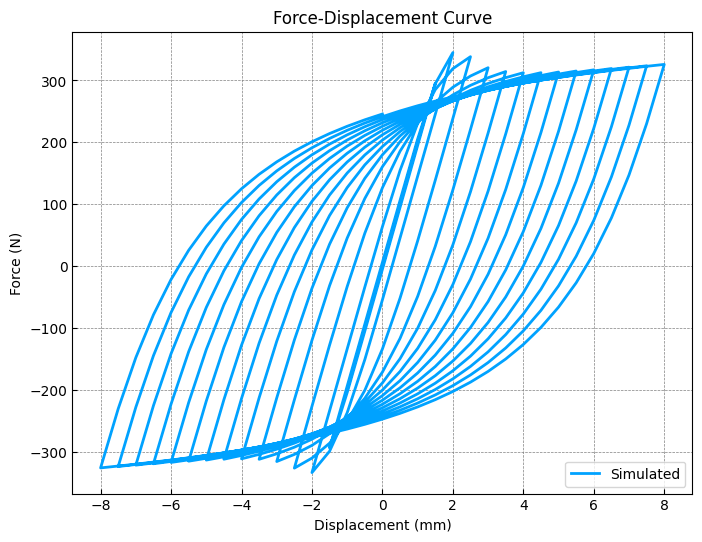

In [6]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.title('Force-Displacement Curve')
plt.plot(disp * UNIT.mm, force * UNIT.n, linewidth=2, color="#00A2FF", label='Simulated', zorder=2)
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.grid(color='gray', linestyle='--', linewidth=0.5, zorder=1)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()

In [7]:
TSs = opsu.post.TrussStates(odb_tag=CASE, ele_tag=tagLib['trussTag'])
TSs.get_steps(data_type='axialForce', stages=(335, 400))

OPSTOOL™ ::  Loading Truss response data from OutData\RespStepData-1.odb ...


 # 导入的原数据：
<xarray.DatasetView> Size: 11kB
Dimensions:     (time: 545, eleTags: 1)
Coordinates:
  * time        (time) float32 2kB 0.0 100.0 -2.91e-08 ... 225.7 236.1 245.5
  * eleTags     (eleTags) int64 8B 1
Data variables:
    axialForce  (time, eleTags) float32 2kB 0.0 100.0 -2.91e-08 ... 236.1 245.5
    axialDefo   (time, eleTags) float32 2kB 0.0 0.5 0.0 -0.5 ... -1.0 -0.5 0.0
    Stress      (time, eleTags) float32 2kB 0.0 100.0 -2.91e-08 ... 236.1 245.5
    Strain      (time, eleTags) float32 2kB 0.0 0.0005 0.0 ... -0.0005 0.0



[0, 28, None]

In [8]:
TSs.get_steps(data_type='Strain', stages=ReBarHub.get_fy('HRB400') / ReBarHub.get_Es('HRB400'))

[0, 28]

In [ ]:
TSs.get_data(data_type='Strain')

steps
0      0.0000
1      0.0005
2      0.0000
3     -0.0005
4      0.0000
        ...  
540   -0.0020
541   -0.0015
542   -0.0010
543   -0.0005
544    0.0000
Name: Strain, Length: 545, dtype: float32

In [10]:
NS = opsu.post.NodalStates(odb_tag=CASE, resp_type="disp")
NS.get_steps(node_tag=tagLib['ctrl_node'], dof='UZ', stages=6)

OPSTOOL™ ::  Loading disp response data from OutData\RespStepData-1.odb ...


 # 导入的原数据：
<xarray.DataArray 'disp' (time: 545, nodeTags: 2, DOFs: 6)> Size: 26kB
array([[[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0.5,  0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ]],

       ...,

       [[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. , -1. ,  0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. , -0.5,  0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ]]],
      shape=(545, 2, 6), dtype=float32)
Coordinates:
  * time      (time) float32 2kB 0.0 100.0 -2.91e-08 ... 225.7 236.1 245.5
  * nodeTags  (nodeTags) int64 16B 1 1001
  * DOFs      (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'



[0, 276]

In [ ]:
NS.get_data(node_tag=tagLib['ctrl_node'], dof='UZ')

steps
0      0.0
1      0.5
2      0.0
3     -0.5
4      0.0
      ... 
540   -2.0
541   -1.5
542   -1.0
543   -0.5
544    0.0
Name: disp, Length: 545, dtype: float32